In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.3 MB/s eta 0:00:00


In [2]:
!git clone https://github.com/coder-zmz/DM-Final.git

Cloning into 'DM-Final'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 104 (delta 39), reused 76 (delta 22), pack-reused 0 (from 0)
Receiving objects: 100% (104/104), 4.82 MiB | 4.75 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [3]:
import nltk
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [36]:
import random
import numpy as np
import torch

# 设置随机种子
seed = 123

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)  # 如果使用 GPU
torch.cuda.manual_seed_all(seed)  # 如果使用多个 GPU
torch.backends.cudnn.deterministic = True  # 保证 cuDNN 的确定性行为
torch.backends.cudnn.benchmark = False  # 禁用 cuDNN 的基准测试，以保证确定性

# 文本特征提取

In [5]:
import warnings
import numpy as np
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

warnings.filterwarnings('ignore')# 忽略警告信息

class LemmaTokenizer:
    """
    自定义分词器,使用WordNetLemmatizer进行词形还原,并过滤掉长度小于3或包含特殊字符的词。
    """
    def __init__(self):
        # 初始化 WordNetLemmatizer 对象，用于词形还原
        self.wnl = WordNetLemmatizer()

    def __call__(self, doc):
        # 对文档中的每个词进行词形还原,并根据条件筛选
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if len(t) >= 3 and "'" not in t and "~" not in t]

def text_embedding(data, max_df=0.8, min_df=0.01, **kwargs):
    """
    使用TF-IDF对输入文本数据进行向量化,并允许自定义参数。

    参数:
    - data: 文本列表,需要向量化的文档。
    - max_features: int, 考虑的最大特征数量。
    - max_df: 浮点数在[0.0, 1.0]之间或整数,最大文档频率。
    - min_df: 浮点数在[0.0, 1.0]之间或整数,最小文档频率。
    - kwargs: 其他传递给TfidfVectorizer的关键字参数。

    返回:
    - x_tfidf: scipy.sparse矩阵,TF-IDF转换后的数据。
    """
    # 设置TfidfVectorizer的参数
    params_tfidf = {
        'analyzer': 'word',           # 分析器类型,这里设置为词级
        'binary': False,              # 是否将所有非零计数设置为1
        'decode_error': 'strict',     # 解码错误处理方式
        'dtype': np.float64,          # 输出矩阵的数据类型
        'encoding': 'utf-8',          # 编码格式
        'input': 'content',           # 输入类型,这里是直接输入文本内容
        'lowercase': True,            # 是否将所有字符转换为小写
        'max_df': max_df,             # 忽略文档频率高于该值的词
        'min_df': min_df,             # 忽略文档频率低于该值的词
        'max_features': None, # 仅用词频排序的前max_features个词创建语料库
        'ngram_range': (1, 2),        # n-grams中n值范围的下限和上限
        'preprocessor': None,         # 预处理器,覆盖预处理步骤
        'stop_words': 'english',      # 停用词表,这里使用英语内置停用词表
        'strip_accents': None,        # 是否去除重音符号
        'token_pattern': '(?u)\\b\\w\\w+\\b', # 分词模式,正则表达式
        'tokenizer': LemmaTokenizer(),# 自定义分词器
        'vocabulary': None,           # 词汇表,默认从输入文件/文本中确定
        'norm': 'l2',                 # 输出结果是否标准化/归一化
        'smooth_idf': True,           # 在文档频率上加1来平滑idf
        'sublinear_tf': True,         # 应用次线性tf缩放
        'use_idf': True,              # 是否计算idf
    }

    # 更新用户传递的其他参数
    params_tfidf.update(kwargs)

    # 创建并应用TfidfVectorizer
    vectorizer = TfidfVectorizer(**params_tfidf)
    x_tfidf = vectorizer.fit_transform(data)
    #print("TF-IDF矩阵:", x_tfidf.toarray())
    # 获取并打印词汇表
    vocabulary = vectorizer.get_feature_names_out()
    #print("词汇表:", vocabulary)

    # 返回稀疏矩阵,避免不必要的内存占用
    return x_tfidf.toarray()


In [6]:
# 测试
train_data = ["Chinese Beijing Chinese ",
        "Chinese Chinese Shanghai",
        "Chinese Macao",
        "Tokyo Japan Chinese"]
print(text_embedding(train_data))

[[0.57735027 0.57735027 0.57735027 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.57735027 0.         0.57735027
  0.         0.         0.         0.57735027 0.         0.        ]
 [0.         0.         0.         0.         0.70710678 0.
  0.         0.         0.70710678 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.5        0.5        0.         0.         0.5        0.5       ]]


# 读取数据

In [7]:
import torch
from torch_geometric.data import Data

def read_data(dataset_name):
    """
    读取cora数据集，并将其转换为torch_geometric的数据格式。

    Args:
        dataset_name: 数据集名称，例如"cora"。

    Returns:
        一个torch_geometric的Data对象，包含节点特征、边索引和节点标签。
        label_name_dict: 标签对应名称的字典。
    """
    # 定义文件路径
    base_path = "/content/DM-Final/data_2/"
    edge_path = base_path + dataset_name + ".edge"
    label_path = base_path + dataset_name + ".label"
    label_name_path = base_path + dataset_name + ".label_name"
    text_path = base_path + dataset_name + ".text"

    # 读取标签对应名称
    label_name_dict = {}
    with open(label_name_path, 'r') as f:
        for line in f:
            label, name = line.strip().split(" ", 1)
            label_name_dict[int(label)] = name

    # 读取边信息
    edges = []
    with open(edge_path, 'r') as f:
        for line in f:
            source, target = map(int, line.strip().split())
            edges.append((source, target))

    # 将边信息转换为PyTorch张量
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    # 读取节点标签
    labels = {}
    with open(label_path, 'r') as f:
        for line in f:
            node_id, label = map(int, line.strip().split())
            labels[node_id] = label

    # 将节点标签转换为PyTorch张量
    y = torch.tensor([labels[i] for i in range(len(labels))], dtype=torch.long)

    # 读取文本特征
    node_texts = {}
    with open(text_path, "r") as f:
        for line in f:
            node_id, text = line.strip().split(" ", 1)  # 以第一个空格分割
            node_texts[int(node_id)] = text

    # 获取节点特征
    node_features = text_embedding(list(node_texts.values()))
    x = torch.tensor(node_features, dtype=torch.float32)

    # 创建Data对象
    data = Data(x=x, edge_index=edge_index, y=y)

    return data, label_name_dict

In [8]:
# 读取cora数据集
cora_data = read_data("cora")
data = cora_data[0]
# 验证数据集
data.validate()

# 获取数据集的类别数量
cora_classes = len(torch.unique(data.y))

# 检查 data.x 的最小值和最大值
min_val = torch.min(data.x)
max_val = torch.max(data.x)

print(f"Minimum value: {min_val}")
print(f"Maximum value: {max_val}")

print(f"data.x.shape: {data.x.shape}")
print(f"data.edge_index.shape: {data.edge_index.shape}")
print(f"data.y.shape: {data.y.shape}")

Minimum value: 0.0
Maximum value: 1.0
data.x.shape: torch.Size([2708, 1150])
data.edge_index.shape: torch.Size([2, 10858])
data.y.shape: torch.Size([2708])


In [9]:
import torch
import numpy as np

# 假设 data.y 是你的节点标签张量
unique_labels, label_counts = torch.unique(data.y, return_counts=True)

# 将结果转换为 NumPy 数组
unique_labels = unique_labels.cpu().numpy()
label_counts = label_counts.cpu().numpy()

for label, count in zip(unique_labels, label_counts):
    label_name = cora_data[1].get(label)
    print(f"类别 {label_name} : {count} 个节点")

类别 Rule_Learning : 180 个节点
类别 Neural_Networks : 818 个节点
类别 Case_Based : 298 个节点
类别 Genetic_Algorithms : 418 个节点
类别 Theory : 351 个节点
类别 Reinforcement_Learning : 217 个节点
类别 Probabilistic_Methods : 426 个节点


# 数据预处理

## 数据可视化

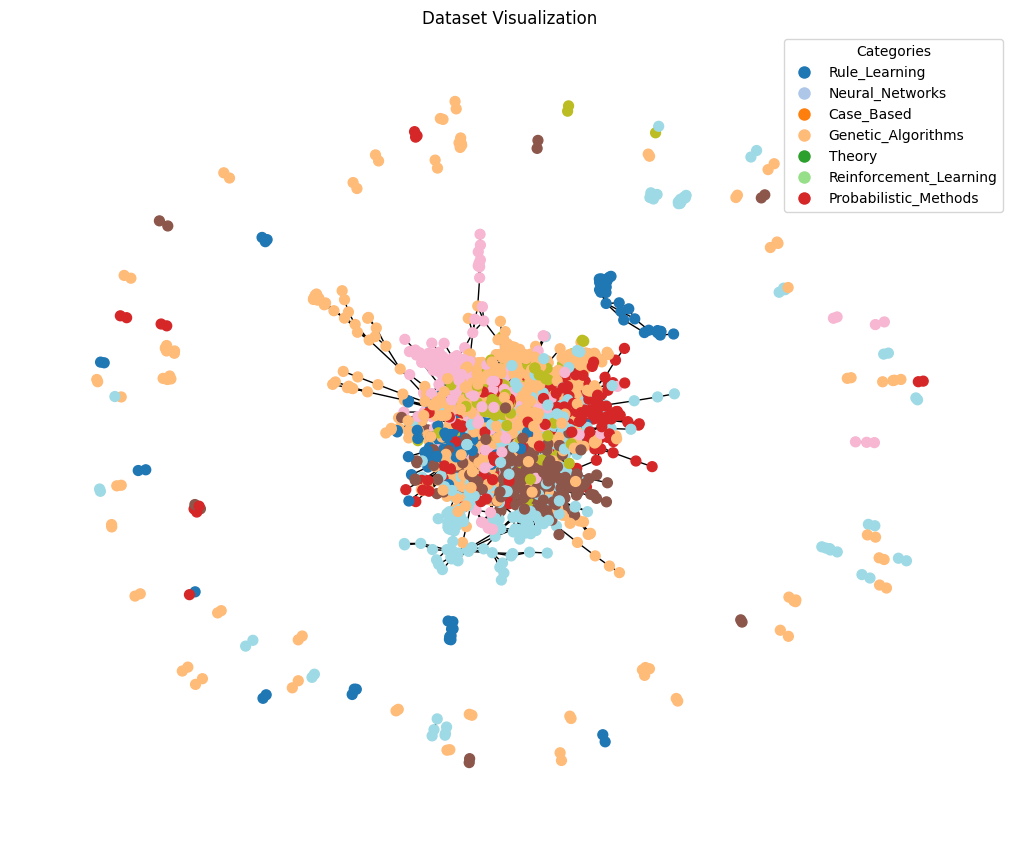

In [10]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def visualize_data(data, label_name_dict):
    """
    可视化图数据。

    Args:
        data: torch_geometric.data.Data 对象，包含节点特征、边索引和节点标签。
        label_name_dict: 标签对应名称的字典。
    """
    # 创建 NetworkX 图对象
    graph = nx.Graph()
    graph.add_edges_from(data.edge_index.t().numpy())

    # 将标签添加到图的节点属性中
    for i, label in enumerate(data.y.numpy()):
        graph.nodes[i]["label"] = label

    # 可视化
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(graph, seed=42)  # 使用 spring_layout 进行布局
    # 为每个节点设置颜色，根据其标签
    node_colors = [graph.nodes[node]["label"] for node in graph.nodes()]
    nx.draw(
        graph,
        pos,
        node_color=node_colors,
        node_size=50,
        cmap=plt.cm.tab20,
        with_labels=False,
    )

    # 添加图例
    handles = []
    for label in np.unique(node_colors):
        if label in label_name_dict:
            handles.append(
                plt.Line2D(
                    [0],
                    [0],
                    marker="o",
                    color="w",
                    label=label_name_dict[label],
                    markerfacecolor=plt.cm.tab20(label),
                    markersize=10,
                )
            )

    plt.legend(handles=handles, title="Categories")
    plt.title("Dataset Visualization")
    plt.show()

# 调用可视化函数
visualize_data(data, cora_data[1])

## 降维

In [11]:
from sklearn.decomposition import PCA

# 创建 PCA 对象，指定降维后的维度
pca = PCA(n_components=500)

# 对特征矩阵进行降维
reduced_features = pca.fit_transform(data.x)

# 将降维后的特征转换为 PyTorch 张量
data.x = torch.tensor(reduced_features, dtype=torch.float32)

# 检查降维后的数据
data.x.shape

torch.Size([2708, 500])

## 按类别划分数据集

In [12]:
import torch
import numpy as np

def split_data(data):
    """
    每种节点选取 40 个作为训练集，并随机选择 1000 个节点作为测试集。

    Args:
        data: torch_geometric.data.Data 对象，包含节点特征、边索引和节点标签。

    Returns:
        更新后的 data 对象，包含 train_mask、val_mask 和 test_mask。
    """
    num_nodes = data.num_nodes
    unique_labels = torch.unique(data.y)  # 获取所有类别标签

    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    for label in unique_labels:
        label_indices = torch.where(data.y == label)[0]  # 获取该类别所有节点的索引
        num_label_nodes = len(label_indices)

        # 训练集节点：每种类别选取 40 个
        train_idx = label_indices[torch.randperm(num_label_nodes)[:40]]
        train_mask[train_idx] = True

    # 测试集节点：随机选择 1000 个
    test_idx = torch.randperm(num_nodes)[:1000]
    test_mask[test_idx] = True

    # 其余节点作为验证集
    val_mask = ~(train_mask | test_mask)

    # 将掩码添加到 data 对象
    data.train_mask = train_mask
    data.val_mask = val_mask
    data.test_mask = test_mask

    return data

In [13]:
data = split_data(data)

train_nodes = data.y[data.train_mask]  # 获取训练集节点的标签
unique_labels, label_counts = torch.unique(train_nodes, return_counts=True)  # 统计每个标签的出现次数

# 将结果转换为字典
class_counts = {label.item(): count.item() for label, count in zip(unique_labels, label_counts)}
for label, count in class_counts.items():
    print(f"类别 {label}: {count} 个节点")


类别 0: 40 个节点
类别 1: 40 个节点
类别 2: 40 个节点
类别 3: 40 个节点
类别 4: 40 个节点
类别 5: 40 个节点
类别 6: 40 个节点


# 模型训练

## 评价函数

In [14]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import torch

def calculate_metrics(model, data, mask):
    """
    计算模型在指定数据集上的所有指标。

    Args:
        model: 模型。
        data: 数据对象。
        mask: 用于选择节点的掩码，例如 data.train_mask 或 data.test_mask。

    Returns:
        一个包含所有指标的字典。
    """
    model.eval()
    with torch.no_grad():  # 禁用梯度计算
      out = model(data.x, data.edge_index)
      probs = torch.nn.functional.softmax(out, dim=1) # 使用 softmax 将模型输出转换为概率
      pred = out.argmax(dim=1).cpu().numpy()  # 获取预测类别
      true = data.y[mask].cpu().numpy()  # 获取真实标签

      # 计算指标
      acc = accuracy_score(true, pred[mask])
      prec = precision_score(true, pred[mask], average='weighted')
      rec = recall_score(true, pred[mask], average='weighted')
      f1 = f1_score(true, pred[mask], average='weighted')
      auc = roc_auc_score(true, probs[mask].cpu().detach().numpy(), multi_class='ovr', average='weighted')

    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'auc': auc}

## 训练函数

In [15]:
import pandas as pd
import torch
from tqdm import tqdm

def train_and_evaluate(model, criterion, optimizer, data, num_epochs=200, patience=10, scheduler=None):
    """
    训练模型并评估其在训练集和测试集上的性能。

    Args:
        model: PyTorch 模型。
        criterion: 损失函数。
        optimizer: 优化器。
        data: PyTorch Geometric 数据对象。
        num_epochs: 训练轮数。
        patience: 早停的 patience 值，即连续多少个 epoch 验证集损失没有下降就停止训练。
        scheduler: 学习率调度器(可选)。

    Returns:
        train_metrics_df: 存储训练集上评价指标的 Pandas DataFrame。
        test_metrics_df: 存储测试集上评价指标的 Pandas DataFrame。
    """

    # 创建 Pandas DataFrame
    train_metrics_df = pd.DataFrame(columns=['epoch', 'loss', 'accuracy', 'precision', 'recall', 'f1', 'auc'])
    test_metrics_df = pd.DataFrame(columns=['epoch', 'accuracy', 'precision', 'recall', 'f1', 'auc'])

    # 初始化早停计数器和最佳验证集损失
    best_val_loss = float('inf')
    early_stop_counter = 0

    # 训练循环
    for epoch in tqdm(range(1, num_epochs + 1)):
        # 训练模型
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # 计算验证集上的Loss
        model.eval()
        with torch.no_grad(): # 禁用梯度计算
          out = model(data.x, data.edge_index)
          val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        # 检查验证集损失是否下降
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        # 如果提供了 scheduler，则更新学习率
        if scheduler is not None:
            scheduler.step(val_loss)

        # 每 20 个 epoch 评估模型性能
        if epoch % 20 == 0 or early_stop_counter >= patience:

            # 计算训练集上的评价指标
            train_metrics = calculate_metrics(model, data, data.train_mask)
            # 计算测试集上的评价指标
            test_metrics = calculate_metrics(model, data, data.test_mask)

            # 将指标添加到 DataFrame
            train_metrics_df.loc[len(train_metrics_df)] = [epoch, loss.item(), train_metrics['accuracy'], train_metrics['precision'], train_metrics['recall'], train_metrics['f1'], train_metrics['auc']]
            test_metrics_df.loc[len(test_metrics_df)] = [epoch, test_metrics['accuracy'], test_metrics['precision'], test_metrics['recall'], test_metrics['f1'], test_metrics['auc']]

            # 打印指标
            """
            print(f'Epoch: {epoch:03d}, Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, '
                  f'Train Acc: {train_metrics["accuracy"]:.4f}, Train Prec: {train_metrics["precision"]:.4f}, Train Rec: {train_metrics["recall"]:.4f}, Train F1: {train_metrics["f1"]:.4f}, Train AUC: {train_metrics["auc"]:.4f}, '
                  f'Test Acc: {test_metrics["accuracy"]:.4f}, Test Prec: {test_metrics["precision"]:.4f}, Test Rec: {test_metrics["recall"]:.4f}, Test F1: {test_metrics["f1"]:.4f}, Test AUC: {test_metrics["auc"]:.4f}')
            """

            # 如果验证集损失连续 patience 个 epoch 没有下降，则停止训练
            if early_stop_counter >= patience:
                print(f'Early stopping at epoch {epoch}')
                break

    return train_metrics_df, test_metrics_df

## 分类结果可视化函数

In [16]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_embeddings(data, label_name_dict, model=None, embeddings=None, title="t-SNE Visualization"):
    """
    使用 t-SNE 可视化嵌入向量。

    Args:
        data: PyTorch Geometric 数据对象。
        label_name_dict: 标签对应名称的字典。
        model: 训练好的模型（可选）。
        embeddings: 预先计算的嵌入向量（可选）。
        title: 图表的标题。
    """

    if embeddings is None and model is None:
        raise ValueError("Must provide either model or embeddings.")

    # 获取嵌入向量（如果未提供）
    if embeddings is None:
        model.eval()
        with torch.no_grad():
            embeddings = model(data.x, data.edge_index)

    # 使用 t-SNE 进行降维
    tsne = TSNE(n_components=2, random_state=42)  # 将嵌入向量降到 2 维
    embeddings_2d = tsne.fit_transform(embeddings.detach().numpy() if isinstance(embeddings, torch.Tensor) else embeddings)

    # 可视化
    plt.figure(figsize=(8, 6))
    for label in torch.unique(data.y):
        indices = (data.y == label).nonzero().squeeze()
        plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1],
                    label=label_name_dict.get(label.item()), s=10)

    plt.legend()
    plt.title(title)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

## CORA+GCN

In [57]:
# @title 默认
from torch_geometric.nn import GCNConv
import torch
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels) -> None:
        super().__init__()
        self.conv1 = GCNConv(data.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, len(torch.unique(data.y)))

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.relu()
        # 对输入的节点特征 x 进行 Dropout 操作，以减少过拟合风险。
        # p=0.5 表示丢弃概率为0.5，即有50%的概率将输入置零。
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.conv2(h, edge_index)
        return h

model = GCN(hidden_channels=8)
print(model)

# 定义损失函数和优化器
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr = 0.01, weight_decay=5e-4)

# 训练并评估模型
cora_train_metrics_default, cora_test_metrics_default = train_and_evaluate(model, criterion, optimizer, data, 500)

print(f"训练集指标:\n{cora_train_metrics_default}")
print(f"测试集指标:\n{cora_test_metrics_default}")

GCN(
  (conv1): GCNConv(500, 8)
  (conv2): GCNConv(8, 7)
)


 42%|████▏     | 211/500 [00:04<00:05, 52.41it/s]

Early stopping at epoch 212
训练集指标:
    epoch      loss  accuracy  precision    recall        f1       auc
0    20.0  1.705056  0.835714   0.855195  0.835714  0.835859  0.963780
1    40.0  1.253863  0.921429   0.927108  0.921429  0.921682  0.988333
2    60.0  0.839007  0.953571   0.956478  0.953571  0.953518  0.996071
3    80.0  0.640860  0.967857   0.969304  0.967857  0.967872  0.998705
4   100.0  0.484037  0.967857   0.969304  0.967857  0.967872  0.999598
5   120.0  0.417906  0.971429   0.972622  0.971429  0.971448  0.999777
6   140.0  0.360902  0.982143   0.982886  0.982143  0.982177  0.999940
7   160.0  0.326385  0.992857   0.992944  0.992857  0.992857  0.999970
8   180.0  0.298771  0.996429   0.996516  0.996429  0.996428  1.000000
9   200.0  0.301176  0.996429   0.996516  0.996429  0.996428  1.000000
10  212.0  0.306906  0.992857   0.993197  0.992857  0.992899  1.000000
测试集指标:
    epoch  accuracy  precision  recall        f1       auc
0    20.0     0.627   0.728061   0.627  0.64494

Text(0, 0.5, 'Accuracy')

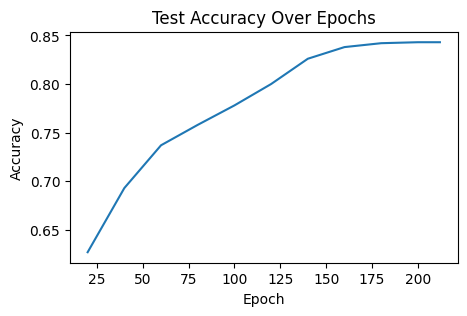

In [58]:
# 可视化测试集指标
import matplotlib.pyplot as plt

# 准确率曲线
plt.figure(figsize=(5, 3))
plt.plot(cora_test_metrics_default['epoch'], cora_test_metrics_default['accuracy'])
plt.title('Test Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [60]:
# @title 网格搜索
from sklearn.model_selection import ParameterGrid
import torch
import pandas as pd

def gcn_grid_search_single_run(data, param_grid, num_epochs=200, target_accuracy=0.9):
    """
    使用网格搜索来优化 GCN 模型。

    Args:
        data: PyTorch Geometric 数据对象。
        param_grid: 超参数空间字典。
        num_epochs: 训练轮数。
        target_accuracy: 目标准确率，达到目标值时停止搜索。

    Returns:
        results_df: 包含所有网格搜索结果的 DataFrame。
    """

    results = []  # 用于存储结果的列表

    # 遍历超参数空间中的所有组合
    for params in ParameterGrid(param_grid):
        print(f"Testing with params: {params}")

        # 创建模型、损失函数和优化器
        model = GCN(hidden_channels=params['hidden_channels'])
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

        # 训练模型
        cora_train_metrics_df, cora_test_metrics_df = train_and_evaluate(model, criterion, optimizer, data, 300)

        # 计算验证集上的分数 (例如，准确率)
        val_score = calculate_metrics(model, data, data.val_mask)['accuracy']
        print(f"Validation accuracy: {val_score:.4f}")

        # 将结果添加到列表中
        results.append({**params, 'accuracy': val_score})  # 使用 **params 将字典解包

        # 检查准确率是否达到目标值
        if val_score >= target_accuracy:
            best_params = params
            print(f"Target accuracy reached! Stopping search with best params: {best_params}")
            break  # 停止搜索

    # 将结果转换为 DataFrame
    results_df = pd.DataFrame(results)

    return results_df

param_grid = {
    'hidden_channels': [8, 16, 32, 64],
    'lr': [0.1, 0.05, 0.01],
    'weight_decay': [5e-4, 1e-3, 5e-3]
}

# 调用函数进行网格搜索
results_df = gcn_grid_search_single_run(data, param_grid, 200, 0.86)

Testing with params: {'hidden_channels': 8, 'lr': 0.1, 'weight_decay': 0.0005}


 18%|█▊        | 54/300 [00:01<00:04, 52.78it/s]


Early stopping at epoch 55
Validation accuracy: 0.8251
Testing with params: {'hidden_channels': 8, 'lr': 0.1, 'weight_decay': 0.001}


 16%|█▌        | 47/300 [00:00<00:04, 50.93it/s]


Early stopping at epoch 48
Validation accuracy: 0.8396
Testing with params: {'hidden_channels': 8, 'lr': 0.1, 'weight_decay': 0.005}


 14%|█▍        | 42/300 [00:00<00:05, 49.62it/s]


Early stopping at epoch 43
Validation accuracy: 0.8225
Testing with params: {'hidden_channels': 8, 'lr': 0.05, 'weight_decay': 0.0005}


 32%|███▏      | 97/300 [00:02<00:05, 39.57it/s]


Early stopping at epoch 98
Validation accuracy: 0.8310
Testing with params: {'hidden_channels': 8, 'lr': 0.05, 'weight_decay': 0.001}


 23%|██▎       | 69/300 [00:01<00:05, 39.38it/s]


Early stopping at epoch 70
Validation accuracy: 0.8310
Testing with params: {'hidden_channels': 8, 'lr': 0.05, 'weight_decay': 0.005}


 21%|██        | 63/300 [00:01<00:04, 51.15it/s]


Early stopping at epoch 64
Validation accuracy: 0.8428
Testing with params: {'hidden_channels': 8, 'lr': 0.01, 'weight_decay': 0.0005}


 80%|████████  | 240/300 [00:04<00:01, 53.65it/s]


Early stopping at epoch 241
Validation accuracy: 0.8219
Testing with params: {'hidden_channels': 8, 'lr': 0.01, 'weight_decay': 0.001}


 57%|█████▋    | 172/300 [00:03<00:02, 53.55it/s]


Early stopping at epoch 173
Validation accuracy: 0.8206
Testing with params: {'hidden_channels': 8, 'lr': 0.01, 'weight_decay': 0.005}


 64%|██████▍   | 193/300 [00:05<00:03, 33.02it/s]


Early stopping at epoch 194
Validation accuracy: 0.8481
Testing with params: {'hidden_channels': 16, 'lr': 0.1, 'weight_decay': 0.0005}


 15%|█▌        | 46/300 [00:01<00:06, 39.45it/s]


Early stopping at epoch 47
Validation accuracy: 0.8324
Testing with params: {'hidden_channels': 16, 'lr': 0.1, 'weight_decay': 0.001}


 11%|█▏        | 34/300 [00:00<00:05, 47.95it/s]


Early stopping at epoch 35
Validation accuracy: 0.8474
Testing with params: {'hidden_channels': 16, 'lr': 0.1, 'weight_decay': 0.005}


 10%|█         | 30/300 [00:00<00:05, 46.48it/s]


Early stopping at epoch 31
Validation accuracy: 0.8337
Testing with params: {'hidden_channels': 16, 'lr': 0.05, 'weight_decay': 0.0005}


 20%|██        | 61/300 [00:01<00:05, 47.36it/s]


Early stopping at epoch 62
Validation accuracy: 0.8337
Testing with params: {'hidden_channels': 16, 'lr': 0.05, 'weight_decay': 0.001}


 18%|█▊        | 55/300 [00:01<00:05, 47.79it/s]


Early stopping at epoch 56
Validation accuracy: 0.8441
Testing with params: {'hidden_channels': 16, 'lr': 0.05, 'weight_decay': 0.005}


 13%|█▎        | 38/300 [00:00<00:05, 48.14it/s]


Early stopping at epoch 39
Validation accuracy: 0.8356
Testing with params: {'hidden_channels': 16, 'lr': 0.01, 'weight_decay': 0.0005}


 54%|█████▎    | 161/300 [00:03<00:02, 48.80it/s]


Early stopping at epoch 162
Validation accuracy: 0.8127
Testing with params: {'hidden_channels': 16, 'lr': 0.01, 'weight_decay': 0.001}


 72%|███████▏  | 216/300 [00:05<00:02, 39.64it/s]


Early stopping at epoch 217
Validation accuracy: 0.8382
Testing with params: {'hidden_channels': 16, 'lr': 0.01, 'weight_decay': 0.005}


 46%|████▌     | 138/300 [00:02<00:03, 48.61it/s]


Early stopping at epoch 139
Validation accuracy: 0.8533
Testing with params: {'hidden_channels': 32, 'lr': 0.1, 'weight_decay': 0.0005}


 13%|█▎        | 39/300 [00:00<00:06, 39.90it/s]


Early stopping at epoch 40
Validation accuracy: 0.8369
Testing with params: {'hidden_channels': 32, 'lr': 0.1, 'weight_decay': 0.001}


  8%|▊         | 24/300 [00:00<00:07, 37.88it/s]


Early stopping at epoch 25
Validation accuracy: 0.8468
Testing with params: {'hidden_channels': 32, 'lr': 0.1, 'weight_decay': 0.005}


  9%|▊         | 26/300 [00:00<00:07, 37.81it/s]


Early stopping at epoch 27
Validation accuracy: 0.8356
Testing with params: {'hidden_channels': 32, 'lr': 0.05, 'weight_decay': 0.0005}


 19%|█▊        | 56/300 [00:01<00:05, 41.39it/s]


Early stopping at epoch 57
Validation accuracy: 0.8330
Testing with params: {'hidden_channels': 32, 'lr': 0.05, 'weight_decay': 0.001}


 14%|█▍        | 43/300 [00:01<00:06, 38.25it/s]


Early stopping at epoch 44
Validation accuracy: 0.8363
Testing with params: {'hidden_channels': 32, 'lr': 0.05, 'weight_decay': 0.005}


 12%|█▏        | 35/300 [00:01<00:09, 27.48it/s]


Early stopping at epoch 36
Validation accuracy: 0.8330
Testing with params: {'hidden_channels': 32, 'lr': 0.01, 'weight_decay': 0.0005}


 48%|████▊     | 143/300 [00:04<00:04, 34.79it/s]


Early stopping at epoch 144
Validation accuracy: 0.8284
Testing with params: {'hidden_channels': 32, 'lr': 0.01, 'weight_decay': 0.001}


 43%|████▎     | 129/300 [00:03<00:04, 40.38it/s]


Early stopping at epoch 130
Validation accuracy: 0.8382
Testing with params: {'hidden_channels': 32, 'lr': 0.01, 'weight_decay': 0.005}


 34%|███▎      | 101/300 [00:02<00:04, 40.22it/s]


Early stopping at epoch 102
Validation accuracy: 0.8546
Testing with params: {'hidden_channels': 64, 'lr': 0.1, 'weight_decay': 0.0005}


 17%|█▋        | 52/300 [00:01<00:08, 28.58it/s]


Early stopping at epoch 53
Validation accuracy: 0.8245
Testing with params: {'hidden_channels': 64, 'lr': 0.1, 'weight_decay': 0.001}


  9%|▉         | 28/300 [00:01<00:14, 19.10it/s]


Early stopping at epoch 29
Validation accuracy: 0.8284
Testing with params: {'hidden_channels': 64, 'lr': 0.1, 'weight_decay': 0.005}


  7%|▋         | 21/300 [00:01<00:15, 17.96it/s]


Early stopping at epoch 22
Validation accuracy: 0.8415
Testing with params: {'hidden_channels': 64, 'lr': 0.05, 'weight_decay': 0.0005}


 19%|█▉        | 58/300 [00:02<00:08, 27.03it/s]


Early stopping at epoch 59
Validation accuracy: 0.8356
Testing with params: {'hidden_channels': 64, 'lr': 0.05, 'weight_decay': 0.001}


 12%|█▏        | 37/300 [00:01<00:09, 28.93it/s]


Early stopping at epoch 38
Validation accuracy: 0.8396
Testing with params: {'hidden_channels': 64, 'lr': 0.05, 'weight_decay': 0.005}


 10%|▉         | 29/300 [00:01<00:09, 28.00it/s]


Early stopping at epoch 30
Validation accuracy: 0.8428
Testing with params: {'hidden_channels': 64, 'lr': 0.01, 'weight_decay': 0.0005}


 41%|████      | 122/300 [00:04<00:06, 29.15it/s]


Early stopping at epoch 123
Validation accuracy: 0.8363
Testing with params: {'hidden_channels': 64, 'lr': 0.01, 'weight_decay': 0.001}


 38%|███▊      | 114/300 [00:04<00:08, 23.15it/s]


Early stopping at epoch 115
Validation accuracy: 0.8461
Testing with params: {'hidden_channels': 64, 'lr': 0.01, 'weight_decay': 0.005}


 26%|██▌       | 77/300 [00:02<00:07, 28.60it/s]

Early stopping at epoch 78
Validation accuracy: 0.8513


In [61]:
# 获取最优
best_params = results_df.loc[results_df['accuracy'].idxmax()]
print(f"Best parameters:\n{best_params}")

Best parameters:
hidden_channels    32.000000
lr                  0.010000
weight_decay        0.005000
accuracy            0.854617
Name: 26, dtype: float64


In [62]:
# @title 调优
from torch_geometric.nn import GCNConv
import torch
import torch.nn.functional as F


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels) -> None:
        super().__init__()
        self.conv1 = GCNConv(data.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, len(torch.unique(data.y)))

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.relu()
        # 对输入的节点特征 x 进行 Dropout 操作，以减少过拟合风险。
        # p=0.5 表示丢弃概率为0.5，即有50%的概率将输入置零。
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.conv2(h, edge_index)
        return h

model = GCN(hidden_channels=32)
print(model)

# 定义损失函数、优化器、学习率调度器
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr = 0.01, weight_decay=0.005)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# 训练并评估模型
cora_train_metrics_tuned, cora_test_metrics_tuned = train_and_evaluate(model, criterion, optimizer, data, 300, 20, scheduler)

print(f"训练集指标:\n{cora_train_metrics_tuned}")
print(f"测试集指标:\n{cora_test_metrics_tuned}")

GCN(
  (conv1): GCNConv(500, 32)
  (conv2): GCNConv(32, 7)
)


 53%|█████▎    | 159/300 [00:04<00:04, 33.84it/s]

Early stopping at epoch 160
训练集指标:
   epoch      loss  accuracy  precision    recall        f1       auc
0   20.0  1.555459  0.900000   0.908270  0.900000  0.900432  0.989271
1   40.0  0.968007  0.939286   0.942301  0.939286  0.939263  0.996443
2   60.0  0.641145  0.939286   0.941820  0.939286  0.939185  0.998318
3   80.0  0.503929  0.950000   0.952649  0.950000  0.950048  0.998884
4  100.0  0.480480  0.953571   0.955885  0.953571  0.953766  0.999063
5  120.0  0.493014  0.957143   0.959548  0.957143  0.957336  0.999107
6  140.0  0.480573  0.953571   0.956078  0.953571  0.953812  0.999092
7  160.0  0.501455  0.953571   0.955885  0.953571  0.953766  0.999107
测试集指标:
   epoch  accuracy  precision  recall        f1       auc
0   20.0     0.816   0.844036   0.816  0.821306  0.959962
1   40.0     0.859   0.868769   0.859  0.859970  0.974975
2   60.0     0.863   0.871165   0.863  0.863706  0.980982
3   80.0     0.861   0.871041   0.861  0.861993  0.982030
4  100.0     0.863   0.871184   0.863 

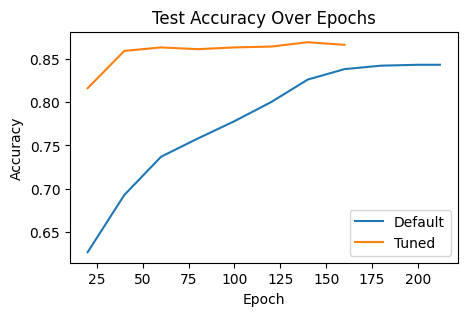

In [63]:
# 可视化
import matplotlib.pyplot as plt

# 调优后测试集上的准确率，叠加调优前的
plt.figure(figsize=(5, 3))
plt.plot(cora_test_metrics_default['epoch'], cora_test_metrics_default['accuracy'], label='Default')
plt.plot(cora_test_metrics_tuned['epoch'], cora_test_metrics_tuned['accuracy'], label='Tuned')
plt.title('Test Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

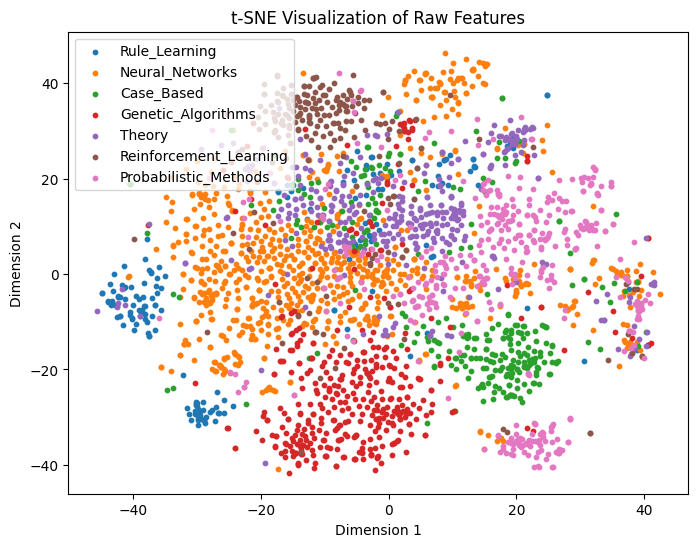

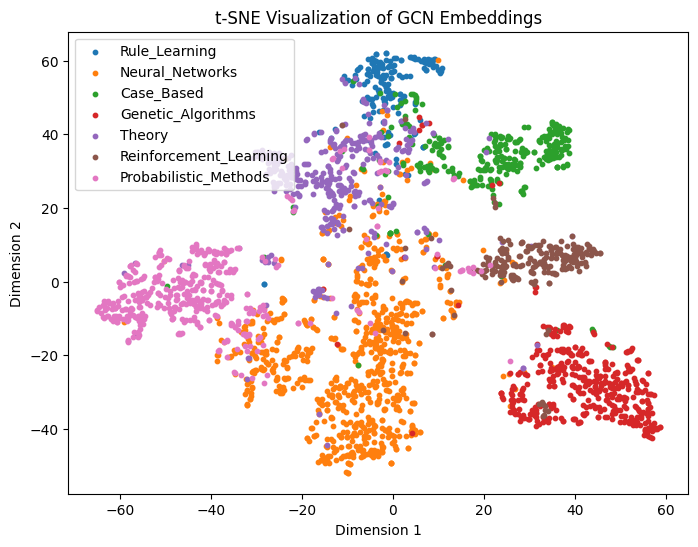

In [ ]:
# @title 可视化分类情况
import matplotlib.pyplot as plt

visualize_embeddings(data, cora_data[1], embeddings=data.x, title="t-SNE Visualization of Raw Features")
visualize_embeddings(data, cora_data[1], model=model, title="t-SNE Visualization of GCN Embeddings")


## CORA+GAT

In [96]:
# @title 默认
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GATConv
import torch
import torch.nn.functional as F

# GAT 模型
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, headers=8):
        super().__init__()
        self.conv1 = GATConv(data.num_node_features, hidden_channels, heads=headers, dropout=0.5)
        # heads参数控制多头注意力机制的头数。
        # dropout参数控制dropout的比例，用于防止过拟合。
        self.conv2 = GATConv(hidden_channels * headers, len(torch.unique(data.y)),heads=1, concat=False, dropout=0.5)
        # concat参数控制是否将多头注意力的结果拼接起来，这里设置为False，表示取平均。


    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=8, headers=8)
print(model)

# 模型训练
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

# 训练并评估模型
train_metrics_df, test_metrics_df = train_and_evaluate(model, criterion, optimizer, data, 500)
print(f"训练集指标:\n{train_metrics_df}")
print(f"测试集指标:\n{test_metrics_df}")

GAT(
  (conv1): GATConv(500, 8, heads=8)
  (conv2): GATConv(64, 7, heads=1)
)


 32%|███▏      | 158/500 [00:09<00:21, 16.02it/s]

Early stopping at epoch 159
训练集指标:
   epoch      loss  accuracy  precision    recall        f1       auc
0   20.0  1.553026  0.928571   0.933630  0.928571  0.928469  0.995506
1   40.0  1.081988  0.935714   0.939078  0.935714  0.935636  0.997798
2   60.0  0.750324  0.950000   0.951845  0.950000  0.949904  0.998765
3   80.0  0.614041  0.971429   0.972778  0.971429  0.971406  0.999107
4  100.0  0.553621  0.982143   0.983065  0.982143  0.982175  0.999554
5  120.0  0.572309  0.989286   0.989713  0.989286  0.989281  0.999702
6  140.0  0.472544  0.992857   0.993031  0.992857  0.992856  0.999911
7  159.0  0.430178  0.992857   0.993031  0.992857  0.992810  0.999985
测试集指标:
   epoch  accuracy  precision  recall        f1       auc
0   20.0     0.787   0.801454   0.787  0.788328  0.952412
1   40.0     0.814   0.823084   0.814  0.814564  0.965750
2   60.0     0.841   0.845033   0.841  0.840915  0.972148
3   80.0     0.847   0.850984   0.847  0.846899  0.974442
4  100.0     0.848   0.853380   0.848 

Text(0, 0.5, 'Accuracy')

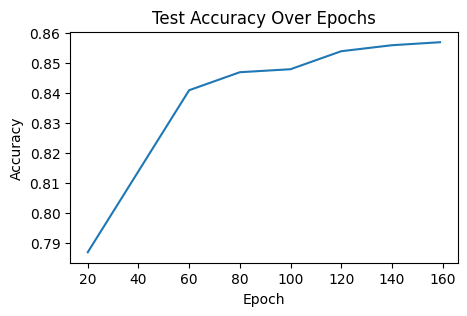

In [97]:
# 可视化测试集指标
import matplotlib.pyplot as plt

# 准确率曲线
plt.figure(figsize=(5, 3))
plt.plot(test_metrics_df['epoch'], test_metrics_df['accuracy'])
plt.title('Test Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [98]:
# @title 网格搜索
import torch
import pandas as pd
from torch.nn import Linear
from torch_geometric.nn import GATConv
from sklearn.model_selection import ParameterGrid
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, num_heads=8):
        super().__init__()
        self.conv1 = GATConv(data.num_node_features, hidden_channels, heads=num_heads, dropout=0.5)
        self.conv2 = GATConv(hidden_channels * num_heads, len(torch.unique(data.y)), heads=1, concat=False, dropout=0.5)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# 修改后的网格搜索函数
def gat_grid_search_single_run(data, param_grid, num_epochs=200, target_accuracy=0.9):
    """
    使用网格搜索来优化 GAT 模型。

    Args:
        data: PyTorch Geometric 数据对象。
        param_grid: 超参数空间字典。
        num_epochs: 训练轮数。
        target_accuracy: 目标准确率，达到目标值时停止搜索。

    Returns:
        results_df: 包含所有网格搜索结果的 DataFrame。
    """

    results = []  # 用于存储结果的列表

    # 遍历超参数空间中的所有组合
    for params in ParameterGrid(param_grid):
        print(f"Testing with params: {params}")

        # 创建模型、损失函数和优化器
        model = GAT(hidden_channels=params['hidden_channels'],
                    num_heads=params['heads'],)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

        # 训练模型
        cora_train_metrics_df, cora_test_metrics_df = train_and_evaluate(model, criterion, optimizer, data, num_epochs)

        # 计算验证集上的分数 (例如，准确率)
        val_score = calculate_metrics(model, data, data.val_mask)['accuracy']
        print(f"Validation accuracy: {val_score:.4f}")

        # 将结果添加到列表中
        results.append({**params, 'accuracy': val_score})  # 使用 **params 将字典解包

        # 检查准确率是否达到目标值
        if val_score >= target_accuracy:
            best_params = params
            print(f"Target accuracy reached! Stopping search with best params: {best_params}")
            break  # 停止搜索

    # 将结果转换为 DataFrame
    results_df = pd.DataFrame(results)

    return results_df

# 定义超参数空间
param_grid = {
    'hidden_channels': [8, 16, 32],
    'lr': [0.05, 0.01],
    'weight_decay': [5e-4, 1e-3, 5e-3],
    'heads': [4, 8, 16],  # GAT 特有的超参数：注意力头的数量
}

# 调用函数进行网格搜索
results_df = gat_grid_search_single_run(data, param_grid, 200, 0.87)

Testing with params: {'heads': 4, 'hidden_channels': 8, 'lr': 0.05, 'weight_decay': 0.0005}


 16%|█▌        | 31/200 [00:01<00:09, 18.37it/s]


Early stopping at epoch 32
Validation accuracy: 0.8055
Testing with params: {'heads': 4, 'hidden_channels': 8, 'lr': 0.05, 'weight_decay': 0.001}


 22%|██▏       | 44/200 [00:02<00:09, 16.06it/s]


Early stopping at epoch 45
Validation accuracy: 0.8225
Testing with params: {'heads': 4, 'hidden_channels': 8, 'lr': 0.05, 'weight_decay': 0.005}


 16%|█▌        | 32/200 [00:01<00:07, 22.88it/s]


Early stopping at epoch 33
Validation accuracy: 0.8513
Testing with params: {'heads': 4, 'hidden_channels': 8, 'lr': 0.01, 'weight_decay': 0.0005}


 58%|█████▊    | 116/200 [00:04<00:03, 23.43it/s]


Early stopping at epoch 117
Validation accuracy: 0.8291
Testing with params: {'heads': 4, 'hidden_channels': 8, 'lr': 0.01, 'weight_decay': 0.001}


 70%|███████   | 141/200 [00:07<00:03, 19.29it/s]


Early stopping at epoch 142
Validation accuracy: 0.8284
Testing with params: {'heads': 4, 'hidden_channels': 8, 'lr': 0.01, 'weight_decay': 0.005}


 53%|█████▎    | 106/200 [00:04<00:04, 23.30it/s]


Early stopping at epoch 107
Validation accuracy: 0.8481
Testing with params: {'heads': 4, 'hidden_channels': 16, 'lr': 0.05, 'weight_decay': 0.0005}


 15%|█▌        | 30/200 [00:01<00:09, 17.73it/s]


Early stopping at epoch 31
Validation accuracy: 0.8304
Testing with params: {'heads': 4, 'hidden_channels': 16, 'lr': 0.05, 'weight_decay': 0.001}


 18%|█▊        | 37/200 [00:02<00:08, 18.29it/s]


Early stopping at epoch 38
Validation accuracy: 0.8402
Testing with params: {'heads': 4, 'hidden_channels': 16, 'lr': 0.05, 'weight_decay': 0.005}


 12%|█▏        | 24/200 [00:01<00:11, 15.40it/s]


Early stopping at epoch 25
Validation accuracy: 0.8350
Testing with params: {'heads': 4, 'hidden_channels': 16, 'lr': 0.01, 'weight_decay': 0.0005}


 54%|█████▍    | 108/200 [00:06<00:05, 15.97it/s]


Early stopping at epoch 109
Validation accuracy: 0.8179
Testing with params: {'heads': 4, 'hidden_channels': 16, 'lr': 0.01, 'weight_decay': 0.001}


 52%|█████▏    | 103/200 [00:05<00:05, 18.33it/s]


Early stopping at epoch 104
Validation accuracy: 0.8147
Testing with params: {'heads': 4, 'hidden_channels': 16, 'lr': 0.01, 'weight_decay': 0.005}


 39%|███▉      | 78/200 [00:05<00:08, 14.88it/s]


Early stopping at epoch 79
Validation accuracy: 0.8481
Testing with params: {'heads': 4, 'hidden_channels': 32, 'lr': 0.05, 'weight_decay': 0.0005}


 24%|██▍       | 49/200 [00:03<00:11, 12.72it/s]


Early stopping at epoch 50
Validation accuracy: 0.8029
Testing with params: {'heads': 4, 'hidden_channels': 32, 'lr': 0.05, 'weight_decay': 0.001}


 13%|█▎        | 26/200 [00:02<00:14, 12.35it/s]


Early stopping at epoch 27
Validation accuracy: 0.8310
Testing with params: {'heads': 4, 'hidden_channels': 32, 'lr': 0.05, 'weight_decay': 0.005}


 10%|█         | 21/200 [00:01<00:14, 12.01it/s]


Early stopping at epoch 22
Validation accuracy: 0.8422
Testing with params: {'heads': 4, 'hidden_channels': 32, 'lr': 0.01, 'weight_decay': 0.0005}


 46%|████▋     | 93/200 [00:08<00:09, 11.45it/s]


Early stopping at epoch 94
Validation accuracy: 0.8147
Testing with params: {'heads': 4, 'hidden_channels': 32, 'lr': 0.01, 'weight_decay': 0.001}


 46%|████▌     | 91/200 [00:07<00:09, 12.09it/s]


Early stopping at epoch 92
Validation accuracy: 0.8330
Testing with params: {'heads': 4, 'hidden_channels': 32, 'lr': 0.01, 'weight_decay': 0.005}


 28%|██▊       | 55/200 [00:04<00:12, 12.04it/s]


Early stopping at epoch 56
Validation accuracy: 0.8337
Testing with params: {'heads': 8, 'hidden_channels': 8, 'lr': 0.05, 'weight_decay': 0.0005}


 18%|█▊        | 35/200 [00:02<00:10, 16.43it/s]


Early stopping at epoch 36
Validation accuracy: 0.8114
Testing with params: {'heads': 8, 'hidden_channels': 8, 'lr': 0.05, 'weight_decay': 0.001}


 19%|█▉        | 38/200 [00:02<00:09, 16.54it/s]


Early stopping at epoch 39
Validation accuracy: 0.8317
Testing with params: {'heads': 8, 'hidden_channels': 8, 'lr': 0.05, 'weight_decay': 0.005}


 14%|█▍        | 28/200 [00:01<00:10, 16.06it/s]


Early stopping at epoch 29
Validation accuracy: 0.8422
Testing with params: {'heads': 8, 'hidden_channels': 8, 'lr': 0.01, 'weight_decay': 0.0005}


 70%|██████▉   | 139/200 [00:09<00:04, 14.86it/s]


Early stopping at epoch 140
Validation accuracy: 0.8265
Testing with params: {'heads': 8, 'hidden_channels': 8, 'lr': 0.01, 'weight_decay': 0.001}


 66%|██████▋   | 133/200 [00:08<00:04, 14.88it/s]


Early stopping at epoch 134
Validation accuracy: 0.8291
Testing with params: {'heads': 8, 'hidden_channels': 8, 'lr': 0.01, 'weight_decay': 0.005}


 41%|████      | 82/200 [00:04<00:07, 16.53it/s]


Early stopping at epoch 83
Validation accuracy: 0.8428
Testing with params: {'heads': 8, 'hidden_channels': 16, 'lr': 0.05, 'weight_decay': 0.0005}


 18%|█▊        | 36/200 [00:02<00:13, 12.05it/s]


Early stopping at epoch 37
Validation accuracy: 0.8179
Testing with params: {'heads': 8, 'hidden_channels': 16, 'lr': 0.05, 'weight_decay': 0.001}


 10%|█         | 21/200 [00:02<00:20,  8.56it/s]


Early stopping at epoch 22
Validation accuracy: 0.8140
Testing with params: {'heads': 8, 'hidden_channels': 16, 'lr': 0.05, 'weight_decay': 0.005}


 11%|█         | 22/200 [00:02<00:18,  9.39it/s]


Early stopping at epoch 23
Validation accuracy: 0.8396
Testing with params: {'heads': 8, 'hidden_channels': 16, 'lr': 0.01, 'weight_decay': 0.0005}


 36%|███▌      | 72/200 [00:05<00:10, 12.38it/s]


Early stopping at epoch 73
Validation accuracy: 0.8278
Testing with params: {'heads': 8, 'hidden_channels': 16, 'lr': 0.01, 'weight_decay': 0.001}


 36%|███▌      | 71/200 [00:06<00:12, 10.15it/s]


Early stopping at epoch 72
Validation accuracy: 0.8140
Testing with params: {'heads': 8, 'hidden_channels': 16, 'lr': 0.01, 'weight_decay': 0.005}


 28%|██▊       | 57/200 [00:04<00:11, 12.34it/s]


Early stopping at epoch 58
Validation accuracy: 0.8474
Testing with params: {'heads': 8, 'hidden_channels': 32, 'lr': 0.05, 'weight_decay': 0.0005}


 10%|█         | 21/200 [00:03<00:26,  6.78it/s]


Early stopping at epoch 22
Validation accuracy: 0.8140
Testing with params: {'heads': 8, 'hidden_channels': 32, 'lr': 0.05, 'weight_decay': 0.001}


 10%|▉         | 19/200 [00:03<00:35,  5.08it/s]


Early stopping at epoch 20
Validation accuracy: 0.8160
Testing with params: {'heads': 8, 'hidden_channels': 32, 'lr': 0.05, 'weight_decay': 0.005}


  8%|▊         | 17/200 [00:03<00:32,  5.55it/s]


Early stopping at epoch 18
Validation accuracy: 0.8088
Testing with params: {'heads': 8, 'hidden_channels': 32, 'lr': 0.01, 'weight_decay': 0.0005}


 33%|███▎      | 66/200 [00:08<00:17,  7.72it/s]


Early stopping at epoch 67
Validation accuracy: 0.8251
Testing with params: {'heads': 8, 'hidden_channels': 32, 'lr': 0.01, 'weight_decay': 0.001}


 24%|██▍       | 48/200 [00:07<00:23,  6.56it/s]


Early stopping at epoch 49
Validation accuracy: 0.8382
Testing with params: {'heads': 8, 'hidden_channels': 32, 'lr': 0.01, 'weight_decay': 0.005}


 22%|██▏       | 44/200 [00:05<00:20,  7.68it/s]


Early stopping at epoch 45
Validation accuracy: 0.8461
Testing with params: {'heads': 16, 'hidden_channels': 8, 'lr': 0.05, 'weight_decay': 0.0005}


 26%|██▋       | 53/200 [00:05<00:16,  9.07it/s]


Early stopping at epoch 54
Validation accuracy: 0.7957
Testing with params: {'heads': 16, 'hidden_channels': 8, 'lr': 0.05, 'weight_decay': 0.001}


 14%|█▎        | 27/200 [00:02<00:15, 11.05it/s]


Early stopping at epoch 28
Validation accuracy: 0.8251
Testing with params: {'heads': 16, 'hidden_channels': 8, 'lr': 0.05, 'weight_decay': 0.005}


 10%|█         | 21/200 [00:01<00:16, 10.83it/s]


Early stopping at epoch 22
Validation accuracy: 0.8245
Testing with params: {'heads': 16, 'hidden_channels': 8, 'lr': 0.01, 'weight_decay': 0.0005}


 42%|████▏     | 83/200 [00:08<00:11,  9.98it/s]


Early stopping at epoch 84
Validation accuracy: 0.8147
Testing with params: {'heads': 16, 'hidden_channels': 8, 'lr': 0.01, 'weight_decay': 0.001}


 44%|████▎     | 87/200 [00:07<00:09, 11.40it/s]


Early stopping at epoch 88
Validation accuracy: 0.8310
Testing with params: {'heads': 16, 'hidden_channels': 8, 'lr': 0.01, 'weight_decay': 0.005}


 27%|██▋       | 54/200 [00:05<00:16,  9.05it/s]


Early stopping at epoch 55
Validation accuracy: 0.8553
Testing with params: {'heads': 16, 'hidden_channels': 16, 'lr': 0.05, 'weight_decay': 0.0005}


 10%|█         | 21/200 [00:03<00:25,  6.97it/s]


Early stopping at epoch 22
Validation accuracy: 0.8258
Testing with params: {'heads': 16, 'hidden_channels': 16, 'lr': 0.05, 'weight_decay': 0.001}


 10%|█         | 20/200 [00:02<00:26,  6.83it/s]


Early stopping at epoch 21
Validation accuracy: 0.7839
Testing with params: {'heads': 16, 'hidden_channels': 16, 'lr': 0.05, 'weight_decay': 0.005}


 10%|▉         | 19/200 [00:02<00:25,  7.18it/s]


Early stopping at epoch 20
Validation accuracy: 0.8415
Testing with params: {'heads': 16, 'hidden_channels': 16, 'lr': 0.01, 'weight_decay': 0.0005}


 24%|██▍       | 49/200 [00:07<00:23,  6.39it/s]


Early stopping at epoch 50
Validation accuracy: 0.8088
Testing with params: {'heads': 16, 'hidden_channels': 16, 'lr': 0.01, 'weight_decay': 0.001}


 38%|███▊      | 75/200 [00:10<00:18,  6.86it/s]


Early stopping at epoch 76
Validation accuracy: 0.8265
Testing with params: {'heads': 16, 'hidden_channels': 16, 'lr': 0.01, 'weight_decay': 0.005}


 20%|██        | 40/200 [00:05<00:21,  7.34it/s]


Early stopping at epoch 41
Validation accuracy: 0.8369
Testing with params: {'heads': 16, 'hidden_channels': 32, 'lr': 0.05, 'weight_decay': 0.0005}


  8%|▊         | 16/200 [00:04<00:53,  3.43it/s]


Early stopping at epoch 17
Validation accuracy: 0.8219
Testing with params: {'heads': 16, 'hidden_channels': 32, 'lr': 0.05, 'weight_decay': 0.001}


  8%|▊         | 17/200 [00:05<00:56,  3.21it/s]


Early stopping at epoch 18
Validation accuracy: 0.7976
Testing with params: {'heads': 16, 'hidden_channels': 32, 'lr': 0.05, 'weight_decay': 0.005}


  8%|▊         | 15/200 [00:04<00:53,  3.49it/s]


Early stopping at epoch 16
Validation accuracy: 0.7976
Testing with params: {'heads': 16, 'hidden_channels': 32, 'lr': 0.01, 'weight_decay': 0.0005}


 18%|█▊        | 36/200 [00:10<00:48,  3.35it/s]


Early stopping at epoch 37
Validation accuracy: 0.8160
Testing with params: {'heads': 16, 'hidden_channels': 32, 'lr': 0.01, 'weight_decay': 0.001}


 24%|██▍       | 49/200 [00:13<00:41,  3.65it/s]


Early stopping at epoch 50
Validation accuracy: 0.8258
Testing with params: {'heads': 16, 'hidden_channels': 32, 'lr': 0.01, 'weight_decay': 0.005}


 17%|█▋        | 34/200 [00:10<00:49,  3.34it/s]

Early stopping at epoch 35
Validation accuracy: 0.8487


In [99]:
# 获取最优
best_params = results_df.loc[results_df['accuracy'].idxmax()]
print(f"Best parameters:\n{best_params}")

Best parameters:
heads              16.000000
hidden_channels     8.000000
lr                  0.010000
weight_decay        0.005000
accuracy            0.855272
Name: 41, dtype: float64


In [108]:
# @title 调优
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GATConv

import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import classification_report

# GAT 模型
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, num_heads=8):
        super().__init__()
        self.conv1 = GATConv(data.num_node_features, hidden_channels, heads=num_heads, dropout=0.5)
        self.conv2 = GATConv(hidden_channels * num_heads, len(torch.unique(data.y)), heads=1, concat=False, dropout=0.5)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# 超参数
hidden_channels = 16  # 尝试不同的隐藏层维度
num_heads = 8         # 尝试不同的注意力头数量
learning_rate = 0.01 # 学习率
weight_decay = 0.005   # 保持权重衰减不变，或根据需要调整
step_size = 20        # 学习率调度器的步长
gamma = 0.1           # 学习率调度器的衰减因子

model = GAT(hidden_channels=hidden_channels, num_heads=num_heads)
print(model)


# 训练并评估模型
# 定义损失函数、优化器、学习率调度器
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# 训练并评估模型
cora_train_metrics_f, cora_test_metrics_f = train_and_evaluate(model, criterion, optimizer, data, 500, 20, scheduler)

print(f"训练集指标:\n{cora_train_metrics_f}")
print(f"测试集指标:\n{cora_test_metrics_f}")

GAT(
  (conv1): GATConv(500, 16, heads=8)
  (conv2): GATConv(128, 7, heads=1)
)


 14%|█▎        | 68/500 [00:06<00:40, 10.70it/s]

Early stopping at epoch 69
训练集指标:
   epoch      loss  accuracy  precision    recall        f1       auc
0   20.0  1.044118  0.928571   0.928975  0.928571  0.928120  0.996920
1   40.0  0.812516  0.946429   0.948293  0.946429  0.946225  0.999003
2   60.0  0.731120  0.953571   0.955238  0.953571  0.953322  0.998780
3   69.0  0.672275  0.957143   0.957681  0.957143  0.956993  0.998869
测试集指标:
   epoch  accuracy  precision  recall        f1       auc
0   20.0     0.849   0.852929   0.849  0.848906  0.979192
1   40.0     0.853   0.858603   0.853  0.853142  0.981883
2   60.0     0.861   0.871643   0.861  0.862253  0.983283
3   69.0     0.865   0.870408   0.865  0.865834  0.982833


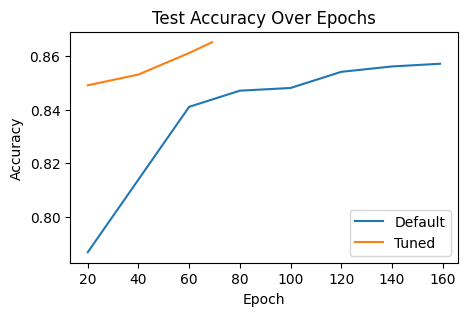

In [109]:
# 可视化
import matplotlib.pyplot as plt

# 调优后测试集上的准确率，叠加调优前的
plt.figure(figsize=(5, 3))
plt.plot(test_metrics_df['epoch'], test_metrics_df['accuracy'], label='Default')
plt.plot(cora_test_metrics_f['epoch'], cora_test_metrics_f['accuracy'], label='Tuned')
plt.title('Test Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

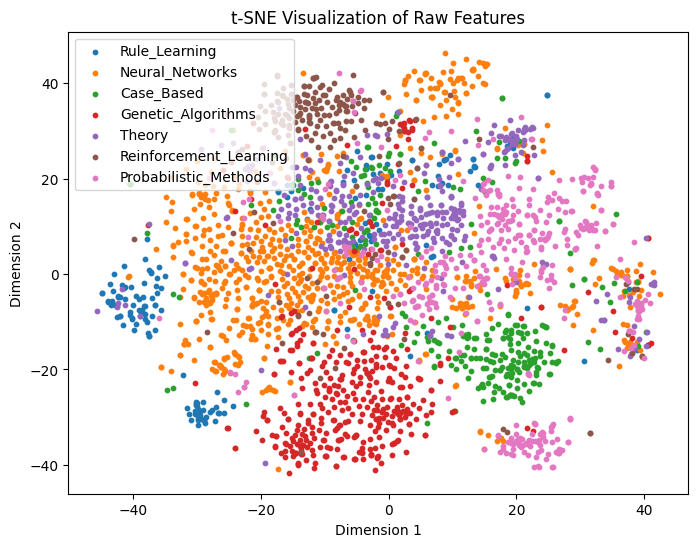

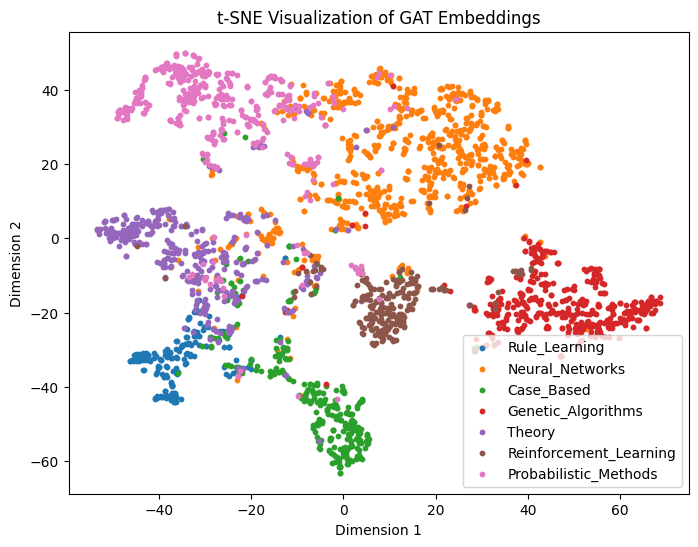

In [110]:
# @title 可视化分类情况
import matplotlib.pyplot as plt

visualize_embeddings(data, cora_data[1], embeddings=data.x, title="t-SNE Visualization of Raw Features")
visualize_embeddings(data, cora_data[1], model=model, title="t-SNE Visualization of GAT Embeddings")
